In [1]:
import glob
import os
import random

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data as data
from torchvision import models, transforms
import torch
import torch.nn.functional as F
import timm
from timm.models.efficientnet import EfficientNet
from sklearn.model_selection import train_test_split
from scipy.stats import hmean
from scipy.spatial import distance
from sklearn.metrics import precision_recall_curve, confusion_matrix

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    

class ImageTransform():
    def __init__(self, size=528, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.transform(img)


def fig_show(img, whole_title=None, figsize=(10, 8)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    ax1.imshow(img)
    ax1.set_title('Original')

    transform = ImageTransform()
    img_transformed = transform(img)

    img_transformed = img_transformed.numpy().transpose((1, 2, 0))
    img_transformed = np.clip(img_transformed, 0, 1)
    ax2.imshow(img_transformed* 255)
    ax2.set_title('transformed')
    if whole_title:
        fig.suptitle(whole_title)
    fig.tight_layout()
    plt.show()

## 画像表示

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


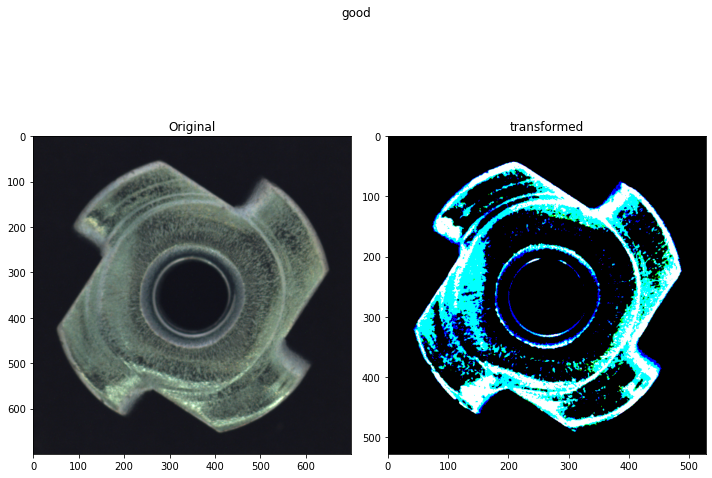

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


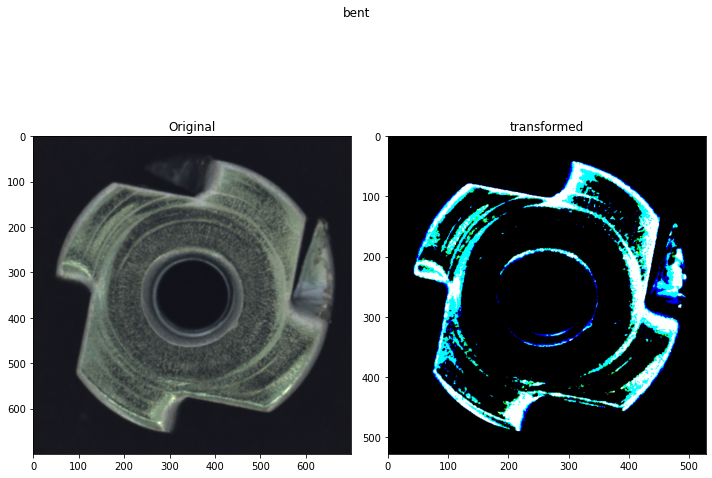

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


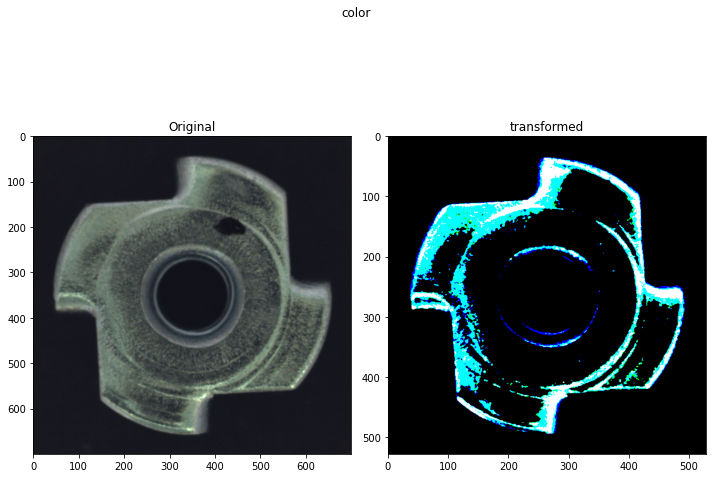

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


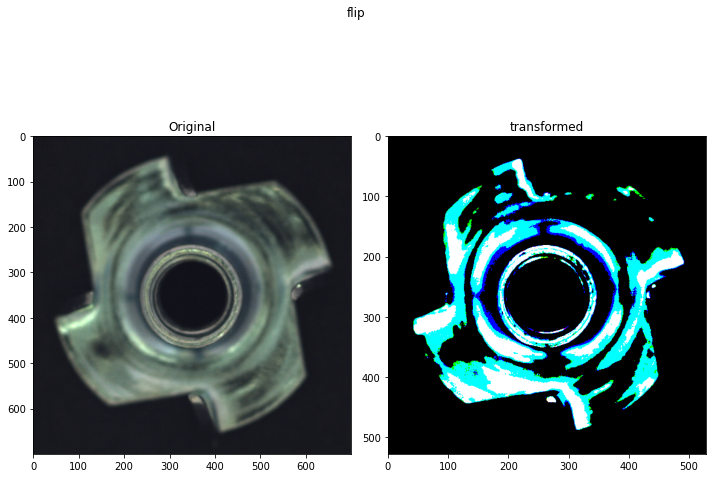

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


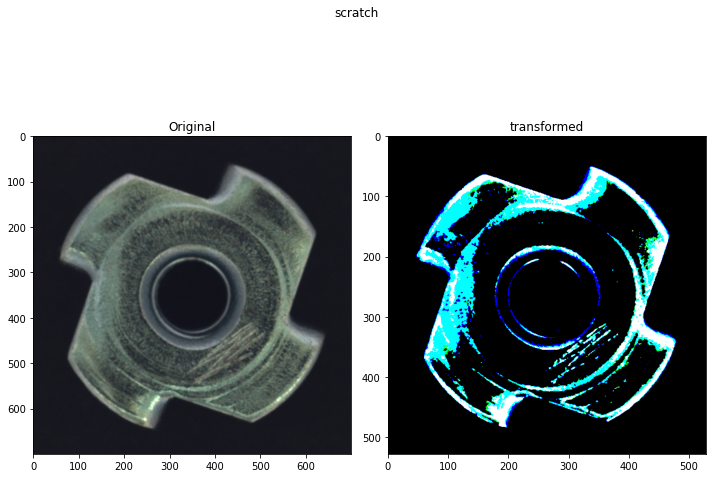

In [3]:
img_path_list = ['../Dataset/good/000.png', '../Dataset/bad/bent/000.png', '../Dataset/bad/color/000.png', '../Dataset/bad/flip/000.png', '../Dataset/bad/scratch/000.png']
img_list = [Image.open(img_path) for img_path in img_path_list]
whole_title_list = ['good', 'bent', 'color', 'flip', 'scratch']
for (img, whole_title) in zip(img_list, whole_title_list):
    fig_show(img, whole_title)

## データセット作成

In [4]:
class Dataset(data.Dataset):
    def __init__(self, img_path_list, transform=ImageTransform()):
        self.img_path_list = img_path_list
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, idx):
        img_path = self.img_path_list[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        return img

In [5]:
# positiveを学習用(特徴量抽出)とテスト用に分けておく
SEED = 42
set_seed(SEED)
normal_path_list = glob.glob('../Dataset/good/*.png')
train_normal_path_list, test_normal_path_list = train_test_split(normal_path_list, test_size=.1, random_state=SEED)
print(f'num normal train: {len(train_normal_path_list)}, num normal test: {len(test_normal_path_list)}')
# 異常画像のファイルパスリスト取得
anomaly_path_list = glob.glob('../Dataset/bad/**/*.png', recursive=True)
print(f'num anomaly: {len(anomaly_path_list)}')

num normal train: 198, num normal test: 22
num anomaly: 93


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


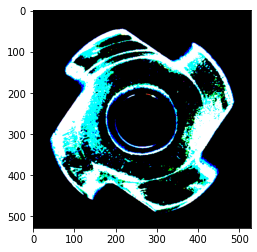

In [6]:
# データセットの動作確認
train_normal_dataset = Dataset(train_normal_path_list)
test_normal_dataset = Dataset(test_normal_path_list)
test_anomaly_dataset = Dataset(anomaly_path_list)

index = 25
out = train_normal_dataset[index]
assert out.size() == torch.Size([3, 528, 528])
img_transformed = out.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed* 255)

## モデル作成 + 特徴量抽出

In [7]:
class MeanCovFromFeature:
    def __init__(self, model, level=7):
        self.model = model
        self.level = level
        
    def _extract_features(self, imgs):
        features = {}
        x = self.model.conv_stem(imgs)
        x = self.model.bn1(x)
        x = self.model.act1(x)
        features['level_1'] = F.adaptive_avg_pool2d(x, 1)
        for i, block_layer in enumerate(self.model.blocks):
            x = block_layer(x)
            features[f'level_{i + 2}'] = F.adaptive_avg_pool2d(x, 1)
        x = self.model.conv_head(x)
        x = self.model.bn2(x)
        x = self.model.act2(x)
        features['level_9'] = F.adaptive_avg_pool2d(x, 1)
        return features[f'level_{self.level}']
    
    def __call__(self, loader):
        feature_list = []
        for imgs in loader:
            features = self._extract_features(imgs)
            # (バッチ数, 特徴量マップ数, 1(height), 1(width))
            features = features.cpu().detach().numpy()
            # 画像ごとに特徴量マップをリストに加えていく
            for i in range(len(features)):
                feature_list.append(features[i].reshape(-1))
        # (画像枚数, 特徴量マップ数)
        feature_arr = np.array(feature_list)
        mean = np.mean(feature_arr, axis=0)
        cov = np.cov(feature_arr.T)
        return feature_arr, mean, cov

In [8]:
# Efficientnetの中間層を用いて特徴量抽出を実施するので学習済みモデルをロード
MODEL_NAME = 'tf_efficientnet_b6_ns'
model = timm.create_model(MODEL_NAME, pretrained=True)
model.eval()
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(56, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
        (bn1): BatchNorm2d(56, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(56, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [9]:
# 画像サイズが大きめなのでバッチサイズが大きいと落ちる(32GBのPCで8バッチを指定すると落ちた)...
batch_size = 1
train_normal_loader = data.DataLoader(
    train_normal_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False
)

test_normal_loader = data.DataLoader(
    test_normal_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False
)

test_anormaly_loader = data.DataLoader(
    test_anomaly_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False
)

MODEL_NAME = 'tf_efficientnet_b6_ns'
model = timm.create_model(MODEL_NAME, pretrained=True)
model.eval()

mean_cov_extractor = MeanCovFromFeature(model)


train_normal_features, mean, cov = mean_cov_extractor(train_normal_loader)
test_normal_features, _, _ = mean_cov_extractor(test_normal_loader)
test_anormaly_features, _, _ = mean_cov_extractor(test_anormaly_loader)

print(f'平均、分散共分散行列取得用データの特徴量形状: {train_normal_features.shape}, 平均の形状:{mean.shape}, 共分散行列の形状: {cov.shape}')
print(f'テスト用正常画像の特徴量形状:{test_normal_features.shape}')
print(f'テスト用異常画像の特徴量形状:{test_anormaly_features.shape}')

平均、分散共分散行列取得用データの特徴量形状: (198, 344), 平均の形状:(344,), 共分散行列の形状: (344, 344)
テスト用正常画像の特徴量形状:(22, 344)
テスト用異常画像の特徴量形状:(93, 344)


## スコアの計算としきい値決め

スコアは、学習用データセット(平均値と分散共分散行列を求めるためのデータセット)から取得した平均値行列と分散共分散行列からのマハラノビス距離で計算する。

マハラノビス距離が小さければ正常、大きければ異常というように判定を実施する。

判定を実施する際に距離のしきい値を決める必要がある。この値を「precisionとrecallの加重平均であるf1スコアが一番高くなるマハラノビス距離」と定義した。

ちなみに、学習用データセットは全て正常と判定できる(箱ひげ図参照)。

In [10]:
def get_score(feat, mean, cov):
    result = []
    # 分散共分散行列の逆行列を計算
    cov_i = np.linalg.pinv(cov)

    for i in range(len(feat)):
        result.append(distance.mahalanobis(feat[i], mean, cov_i))
    return result


train_score = get_score(train_normal_features, mean, cov)
normal_score = get_score(test_normal_features, mean, cov)
anomaly_score = get_score(test_anormaly_features, mean, cov)

<AxesSubplot:xlabel='data type', ylabel='score'>

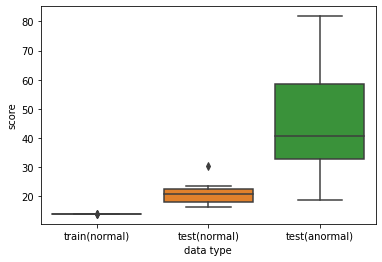

In [11]:
# スコア分布の箱ひげ図。図から、学習用の正常データとテスト用異常データは完全に分離することが可能であることがわかる。
df4box_plot = pd.DataFrame({
    'score': train_score + normal_score + anomaly_score,
    'data type': (['train(normal)'] * len(train_score)) + (['test(normal)'] * len(normal_score) + (['test(anormal)'] * len(anomaly_score)))
})
sns.boxplot(data=df4box_plot, x='data type', y='score')

23番目のしきい値(24.59) で一番高い f1 score(0.98) をとる。


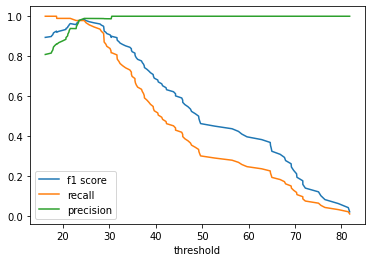

In [12]:
def get_precision_recall(Z1, Z2):
    # 0:正常、1：異常
    y_true = np.zeros(len(Z1) + len(Z2))
    y_true[len(Z1):] = 1
    precision, recall, thresholds = precision_recall_curve(y_true, np.hstack((Z1, Z2)))
    
    return precision, recall, thresholds


precision, recall, thresholds = get_precision_recall(normal_score, anomaly_score)
f1_scores = []
for p, r in zip(precision, recall):
    f1 = hmean([p, r])
    f1_scores.append(f1)

# しきい値と各種評価指標の関係性をプロット
plt.plot(thresholds, f1_scores[:-1], label='f1 score')
plt.plot(thresholds, recall[:-1], label='recall')
plt.plot(thresholds, precision[:-1], label='precision')
plt.xlabel('threshold')
plt.legend()

highest_f1_score_idx = np.argmax(f1_scores)
highest_f1_score = f1_scores[highest_f1_score_idx]
best_threshold = thresholds[highest_f1_score_idx]
print(f'{highest_f1_score_idx}番目のしきい値({best_threshold:.2f}) で一番高い f1 score({highest_f1_score:.2f}) をとる。')

## 求めたしきい値で予測 + 混同行列描画

しきい値を求めたので、求めたしきい値を用いて異常検知を実施する。

その際の混同行列を描画しておく。

補足として、上述のように学習用データセットにおいては全て正常と判定できるので考慮にいれていない。

In [13]:
# 予測の実施
predicted_df = pd.DataFrame({
    'score': normal_score + anomaly_score,
    'labels': ([0] * len(normal_score)) + ([1] * len(anomaly_score)),
    'img_path': test_normal_path_list + anomaly_path_list
})
# しきい値以下 => 0, それ以外 => 1として予測
predicted_df['predicted'] = predicted_df['score'].apply(lambda x: 0 if x < best_threshold else 1)

Text(69.0, 0.5, 'predicted label')

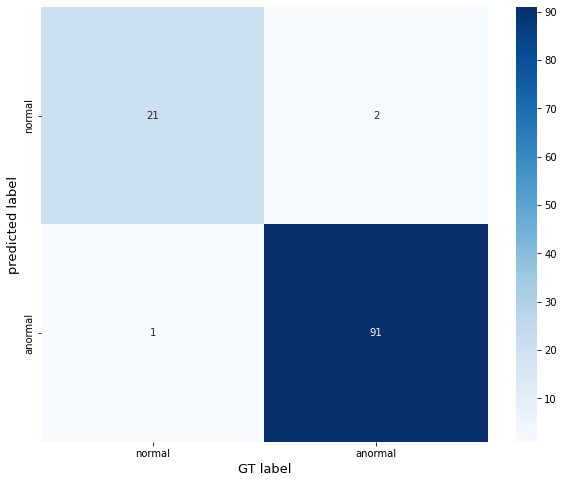

In [14]:
# 混同行列の描画
cm = confusion_matrix(y_true=predicted_df['labels'], y_pred=predicted_df['predicted']).T
cm_df = pd.DataFrame(cm, index=['normal', 'anormal'], columns=['normal', 'anormal'])
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, ax=ax, cmap='Blues')
ax.set_xlabel('GT label', fontsize=13)
ax.set_ylabel('predicted label', fontsize=13)

## 間違えた異常データを確認してみる

上の混同行列から、2つの異常データを誤って正常と判定してしまっていることがわかる。こちらがどの画像かを確かめて可視化する。

いずれの画像も「scratch」とラベルされていることがわかる。

../Dataset/bad/scratch/020.png


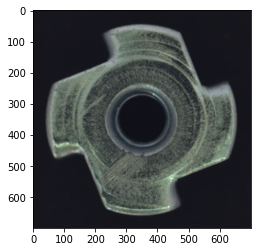

../Dataset/bad/scratch/000.png


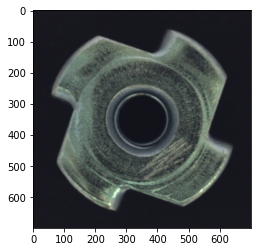

In [15]:
# 異常画像のうち、間違えた画像のデータフレームを取得
missed_anormal_img_path_list = predicted_df[(predicted_df['labels'] == 1) & (predicted_df['predicted'] == 0)]['img_path'].to_list()
# 画像を描画
for img_path in missed_anormal_img_path_list:
    print(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()